## Import Library

In [56]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Fungsi Ekstraksi Fitur (HOG + Statistik Intensitas)

In [57]:
from skimage.feature import hog

def extract_features(img):
    """
    Ekstraksi fitur dari citra:
    - HOG
    - Mean intensity
    - Standard deviation intensity
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))

    # Ekstrak HOG
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )

    # Opsional: tambahkan fitur global
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)

    # Gabungkan
    features = np.hstack([hog_features, mean_intensity, std_intensity])
    return features

## Inisiasi Folder Dataset & Class

In [58]:
data = []
labels = []

base = "dataset3/train"
classes = ["50", "100", "200", "500", "1000"]

## Load Dataset & Extract Feature

In [59]:
for cls in classes:
  folder = os.path.join(base, cls)
  for file in os.listdir(folder):
    path = os.path.join(folder, file)
    img = cv2.imread(path)

    if img is None:
      continue

    feat = extract_features(img) 
    data.append(feat)
    labels.append(cls)

data = np.array(data)
labels = np.array(labels)

## Statistik Awal Dataset

In [60]:
from collections import Counter

print("### STATISTIK DATASET AWAL ###")
print(f"Total Sampel: {len(data)}")
print("Distribusi Kelas Awal:")

# Menghitung distribusi kelas (Counter(labels) akan menghasilkan: {'1000': 245, '500': 240, ...})
initial_counts = Counter(labels)

# Print berdasarkan urutan nominal
for cls in sorted(classes, key=int):
    count = initial_counts.get(cls, 0)
    print(f"- Kelas {cls}: {count} sampel")

### STATISTIK DATASET AWAL ###
Total Sampel: 904
Distribusi Kelas Awal:
- Kelas 50: 28 sampel
- Kelas 100: 189 sampel
- Kelas 200: 201 sampel
- Kelas 500: 239 sampel
- Kelas 1000: 247 sampel


## Splitting Dataset & Statistik

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
  data, labels, test_size=0.2, random_state=42, stratify=labels
)

print("### STATISTIK PEMBAGIAN DATA ###")
print(f"Ukuran Data Traint (Training Set): {len(X_train)} sampel")
print(f"Ukuran Data Test (Testing Set): {len(X_test)} sampel")

train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("\nDistribusi Kelas (Data Train):")
for cls in sorted(classes, key=int):
    print(f"- Kelas {cls}: {train_counts.get(cls, 0)} sampel")

print("\nDistribusi Kelas (Data Test):")
for cls in sorted(classes, key=int):
    print(f"- Kelas {cls}: {test_counts.get(cls, 0)} sampel")

### STATISTIK PEMBAGIAN DATA ###
Ukuran Data Traint (Training Set): 723 sampel
Ukuran Data Test (Testing Set): 181 sampel

Distribusi Kelas (Data Train):
- Kelas 50: 22 sampel
- Kelas 100: 151 sampel
- Kelas 200: 161 sampel
- Kelas 500: 191 sampel
- Kelas 1000: 198 sampel

Distribusi Kelas (Data Test):
- Kelas 50: 6 sampel
- Kelas 100: 38 sampel
- Kelas 200: 40 sampel
- Kelas 500: 48 sampel
- Kelas 1000: 49 sampel


## Training & Prediksi Model Menggunakan RandomForest dan Evaluasi

In [62]:
import joblib

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("\n### CLASSIFICATION REPORT (DATA UJI INTERNAL) ###")
print(classification_report(y_test, pred))

joblib.dump(model, "coin_rf.pkl")


### CLASSIFICATION REPORT (DATA UJI INTERNAL) ###
              precision    recall  f1-score   support

         100       0.65      0.34      0.45        38
        1000       0.61      0.76      0.67        49
         200       0.67      0.65      0.66        40
          50       1.00      0.67      0.80         6
         500       0.63      0.75      0.69        48

    accuracy                           0.64       181
   macro avg       0.71      0.63      0.65       181
weighted avg       0.65      0.64      0.63       181



['coin_rf.pkl']

## Visualisasi HOG

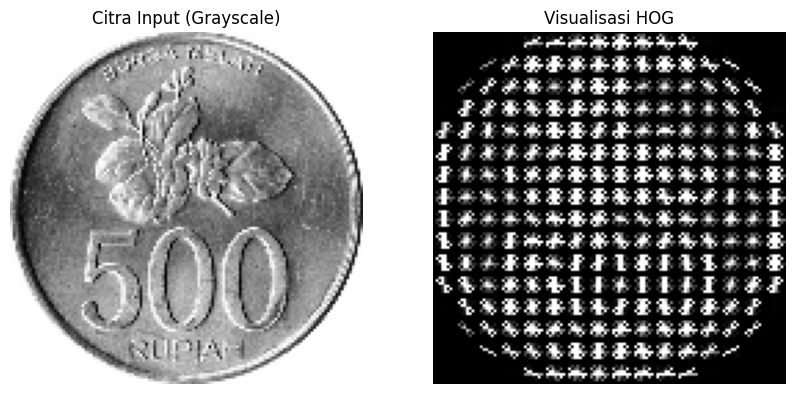

In [63]:
from skimage import exposure

sample_dir = os.path.join(base, "500")
sample_files = os.listdir(sample_dir)
sample_path = os.path.join(sample_dir, "IMG_500_003.jpg")

if sample_path:
    img = cv2.imread(sample_path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 128))
        
        # Ekstrak HOG dengan visualize=True
        hog_features, hog_image = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            feature_vector=True,
            visualize=True
        )

        # Plot hasilnya
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

        ax1.axis('off')
        ax1.imshow(gray, cmap=plt.cm.gray)
        ax1.set_title('Citra Input (Grayscale)')

        # Rescale histogram of gradients for better visibility
        hog_image_rescaled = hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Visualisasi HOG')

        plt.show()
        
    else:
        print(f"Gagal memuat gambar dari {sample_path}")
else:
    print("Gagal mendapatkan path gambar sampel untuk visualisasi HOG.")

## Test Akurasi Dengan Folder

In [64]:
correct = 0
total = 0

base = "dataset3/test"

for cls in classes:
  folder = os.path.join(base, cls)
  for file in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, file))
    
    if img is None:
      continue

    feat = extract_features(img).reshape(1, -1)
    pred = model.predict(feat)[0]

    print(file, "=> pred:", pred, " | true:", cls)

    total += 1
    correct += (pred == cls)

print("\nAccuracy test folder:", correct / total)

IMG_50_000.jpg => pred: 50  | true: 50
IMG_50_001.jpg => pred: 50  | true: 50
IMG_50_002.jpg => pred: 50  | true: 50
IMG_50_003.jpg => pred: 50  | true: 50
IMG_100_000.jpg => pred: 100  | true: 100
IMG_100_001.jpg => pred: 100  | true: 100
IMG_100_002.jpg => pred: 100  | true: 100
IMG_100_003.jpg => pred: 100  | true: 100
IMG_200_000.jpg => pred: 200  | true: 200
IMG_200_001.jpg => pred: 100  | true: 200
IMG_200_002.jpg => pred: 200  | true: 200
IMG_200_003.jpg => pred: 200  | true: 200
IMG_500_000.jpg => pred: 500  | true: 500
IMG_500_001.jpg => pred: 500  | true: 500
IMG_500_002.jpg => pred: 500  | true: 500
IMG_500_003.jpg => pred: 1000  | true: 500
IMG_1000_000.jpg => pred: 1000  | true: 1000
IMG_1000_001.jpg => pred: 1000  | true: 1000
IMG_1000_002.jpg => pred: 1000  | true: 1000
IMG_1000_003.jpg => pred: 1000  | true: 1000

Accuracy test folder: 0.9


## Aplikasi Gradio (PCD)

In [ ]:
import gradio as gr
import cv2
import numpy as np
import joblib
from collections import Counter

# Load model
model = joblib.load("coin_rf.pkl")

# Label koin dan nilainya
coin_values = {
    '50': 50,
    '100': 100,
    '200': 200,
    '500': 500,
    '1000': 1000
}

# Fungsi deteksi koin (dilingkari)
def detect_coins(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    morph = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)

    cnts, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circles = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 2500:
            continue

        (x, y), r = cv2.minEnclosingCircle(c)
        circles.append((int(x), int(y), int(r)))

    return circles

def detect_and_label(image):
    if image is None:
        return None, ""

    img = image.copy()
    circles = detect_coins(img)

    predictions = []
    label_text = ""

    if not circles:
        label_text = "❌ Tidak ada koin terdeteksi."
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb, label_text

    label_text += f"✅ Terdeteksi {len(circles)} koin\n\n"
    label_text += "Hasil Klasifikasi:\n"
    label_text += "-" * 40 + "\n\n"

    for i, (x, y, r) in enumerate(circles, 1):
        x1 = max(0, x - r)
        y1 = max(0, y - r)
        x2 = min(img.shape[1], x + r)
        y2 = min(img.shape[0], y + r)

        coin = img[y1:y2, x1:x2]
        if coin.size == 0:
            continue

        feat = extract_features(coin).reshape(1, -1)
        pred = model.predict(feat)[0]
        proba = model.predict_proba(feat)[0]

        classes = model.classes_
        prob_with_label = list(zip(classes, proba))
        prob_with_label.sort(key=lambda x: x[1], reverse=True)
        top3 = prob_with_label[:3]

        predictions.append(pred)

        label_text += f"Koin {i}: {pred}\n"
        label_text += "  Top 3 predictions:\n"
        for label, conf in top3:
            label_text += f"    {label:5} : {conf*100:6.1f}%\n"
        label_text += "\n"

    label_text += "=" * 40 + "\n\n"
    label_text += "Ringkasan:\n"

    counter = Counter(predictions)
    total_value = 0
    for coin, count in counter.items():
        nominal = coin_values.get(coin, 0)
        total_value += nominal * count
        label_text += f"- {coin}: {count}x = Rp {nominal * count:,}\n"

    label_text += f"\n💰 TOTAL NILAI: Rp {total_value:,}"

    # Gambar hasil
    for (x, y, r), pred in zip(circles, predictions):
        cv2.circle(
            img, 
            (x, y), 
            r, 
            (0, 255, 0), 
            3
        )
        cv2.putText(
            img, 
            pred, (x - r, y - r - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (255, 0, 0), 
            3
        )

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb, label_text


with gr.Blocks() as demo:
    gr.Markdown("## Deteksi & Klasifikasi Koin Rupiah — RandomForest")

    with gr.Row():
        with gr.Column():
            inp = gr.Image(type="numpy", label="Upload Gambar")
            btn = gr.Button("Deteksi Koin")

        with gr.Column():
            out_img = gr.Image(type="numpy", label="Hasil Deteksi")
            out_text = gr.Textbox(label="Ringkasan Hasil", lines=15, max_lines=25)

    btn.click(detect_and_label, inputs=inp, outputs=[out_img, out_text])

demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        self.scope, self.receive, self.send
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastapi\applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\starlette\applications.py", line 107, in __call__
    await self.